## Forced photometry plot
Oct 18

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as so

%matplotlib inline


def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, color='#bf1d7e',alphaval=1.0,ax=None, **contour_kwargs):
    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1)) 
    pdf = (H*(x_bin_sizes*y_bin_sizes))
 
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    
    levels = [one_sigma,two_sigma]
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    contour = plt.contour(X, Y, Z, levels=levels,linewidths=2,colors=color,alpha=alphaval)
    return contour

def flux2mag(f):
    m=np.zeros_like(f)
    for i in range(len(f)):
        if f[i]>0:
            m[i]=-2.5*np.log10(f[i])+23.9
        else:
            m[i]=-99.0
    return m

In [40]:
a = np.genfromtxt('blending_results.txt')

Text(0, 0.5, 'Lores blended flux')

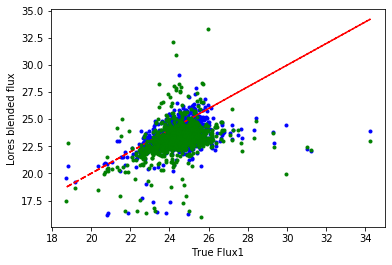

In [41]:
Xl,Yl = flux2mag(a[:,0]),flux2mag(a[:,10])
X = Xl[(Xl>10)&(Yl>10)]
Y = Yl[(Yl>10)&(Xl>10)]
plt.plot(X,Y,'b.')
plt.plot(X,X,'r--')
Xl,Yl = flux2mag(a[:,0]),flux2mag(a[:,15])
X = Xl[(Xl>10)&(Yl>10)]
Y = Yl[(Yl>10)&(Xl>10)]
plt.plot(X,Y,'g.')
plt.xlabel('True Flux1')
plt.ylabel('Lores blended flux')

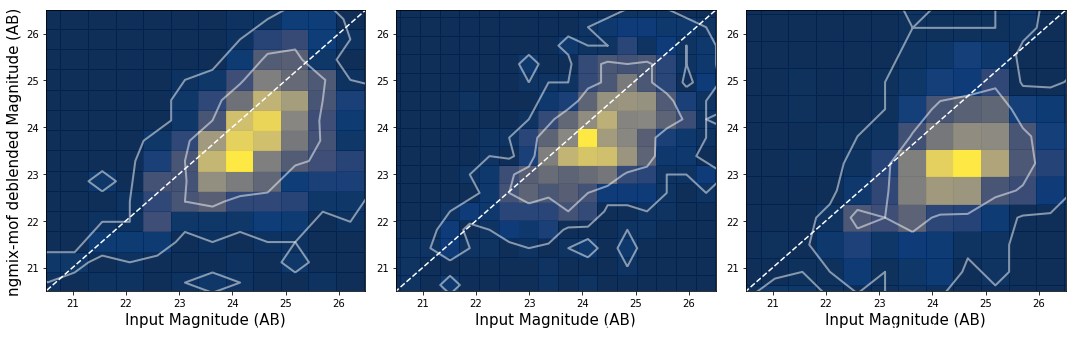

In [42]:

bb = 30  

font = {'family' : 'sans-serif',
        'fontname' : 'Times New Roman',
        'size'   : 20}
plt.figure(figsize = (15,5))                              

Xl,Yl = flux2mag(a[:,0]),flux2mag(a[:,10])
X = Xl[(Xl>0)&(Yl>0)]
Y = Yl[(Yl>0)&(Xl>0)]
plt.subplot(1,3,1)
plt.hist2d(X,Y,bins=[bb,bb],cmap='cividis',zorder=1,alpha=0.94)
plt.plot([19,27],[19,27],'w--')
o=density_contour(X,Y,bb,bb,zorder=3,color='w',alphaval=0.5)
plt.text(23.5,19.5,'1st Gal',color='w',size=20)

plt.xlim([20.5,26.5])
plt.ylim([20.5,26.5])
plt.xlabel('Input Magnitude (AB)',size=15)
plt.ylabel('ngmix-mof deblended Magnitude (AB)',size=15)


plt.subplot(1,3,2)
Xl,Yl = flux2mag(a[:,1]),flux2mag(a[:,11])
X = Xl[(Xl>0)&(Yl>0)]
Y = Yl[(Yl>0)&(Xl>0)]
plt.hist2d(X,Y,bins=[bb,bb],cmap='cividis',zorder=1,alpha=0.94)
plt.plot([19,27],[19,27],'w--')
o=density_contour(X,Y,bb,bb,zorder=3,color='w',alphaval=0.5)
plt.text(23.5,19.5,'2nd Gal',color='w',size=20)

plt.xlim([20.5,26.5])
plt.ylim([20.5,26.5])
plt.xlabel('Input Magnitude (AB)',size=15)


plt.subplot(1,3,3)
Xl,Yl = flux2mag(a[:,0]),flux2mag(a[:,15])
X = Xl[(Xl>0)&(Yl>0)]
Y = Yl[(Yl>0)&(Xl>0)]
plt.hist2d(X,Y,bins=[bb,bb],cmap='cividis',zorder=1,alpha=0.94)
plt.plot([19,27],[19,27],'w--')
plt.text(23,19.5,'Blended',color='w',size=20)
o=density_contour(X,Y,bb,bb,zorder=3,color='w',alphaval=0.5)
  
plt.xlim([20.5,26.5])
plt.ylim([20.5,26.5])
plt.xlabel('Input Magnitude (AB)',size=15)
plt.tight_layout()
#plt.ylabel('Measured Magnitude (AB)')
plt.savefig('../plots/photometry.png')

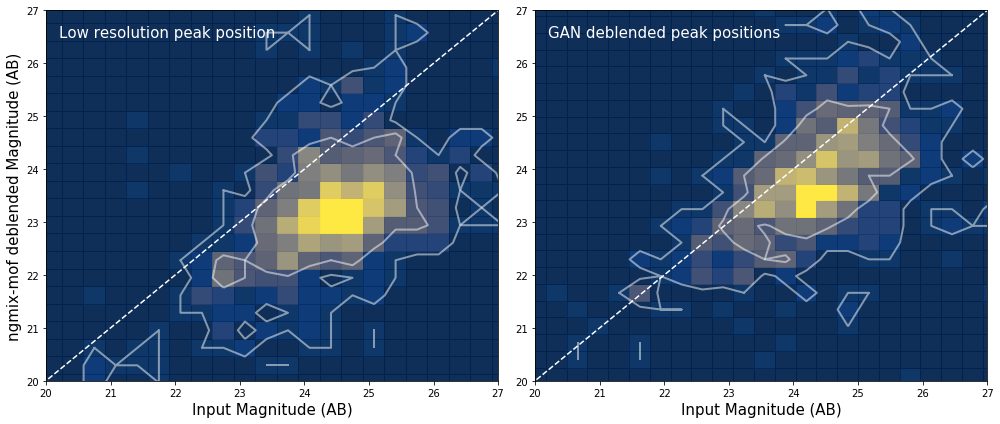

In [60]:
bb = 400 

font = {'family' : 'sans-serif',
        'fontname' : 'Times New Roman',
        'size'   : 20}
plt.figure(figsize = (14,6))                              
X,Y = flux2mag(a[:,1]),flux2mag(a[:,11])

plt.subplot(1,2,2)
plt.hist2d(X,Y,vmax=25,bins=[bb,bb],cmap='cividis',zorder=1,alpha=0.94)
#plt.hexbin(X,Y, gridsize=300,vmin=0,vmax=55,cmap='cividis',alpha=0.94)
plt.plot([19,27],[19,27],'w--')
X,Y = flux2mag(a[:,1]),flux2mag(a[:,11])
o=density_contour(X,Y,bb,bb,zorder=3,color='w',alphaval=0.5)
plt.xlim([20,27])
plt.ylim([20,27])
plt.xlabel('Input Magnitude (AB)',size=15)
plt.text(20.2,26.5,'GAN deblended peak positions',color='w',size=15)



plt.subplot(1,2,1)
X,Y = flux2mag(a[:,0]),flux2mag(a[:,15])

plt.hist2d(X,Y,vmax=25,bins=[bb,bb],cmap='cividis',zorder=1,alpha=0.94)
#plt.hexbin(X,Y, gridsize=300,vmin=0,vmax=55,cmap='cividis',alpha=0.94)
plt.plot([19,27],[19,27],'w--')
plt.text(20.2,26.5,'Low resolution peak position',color='w',size=15)
o=density_contour(X,Y,bb,bb,zorder=3,color='w',alphaval=0.5)
  
plt.xlim([20,27])
plt.ylim([20,27])
plt.xlabel('Input Magnitude (AB)',size=15)
plt.ylabel('ngmix-mof deblended Magnitude (AB)',size=15)

plt.tight_layout()
#plt.ylabel('Measured Magnitude (AB)')
#plt.savefig('../plots/photometry.png')

In [79]:
def density_contour(xdata, ydata, nbins_x, nbins_y, color='#bf1d7e',alphaval=1.0,ax=None, **contour_kwargs):
    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1)) 
    pdf = (H*(x_bin_sizes*y_bin_sizes))
 
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    
    levels = [one_sigma]#,two_sigma]
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    contour = plt.contour(X, Y, Z, levels=levels,linewidths=2,colors=color,alpha=alphaval)
    return contour

def runmed(X,Y,total_bins):
    bins = np.linspace(22,26, total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(X,bins)
    running_median = [np.median(Y[idx==k]) for k in range(total_bins)]
    xr=bins-delta/2
    a=[xr,running_median]
    return a

def plot_photcomp(cndmag,hstmag,bb):
    
    X=cndmag[(cndmag!=-99.0)&(hstmag!=-99.0)]
    Y=cndmag[(cndmag!=-99.0)&(hstmag!=-99.0)]-hstmag[(cndmag!=-99.0)&(hstmag!=-99.0)]
    rm=runmed(X,Y,20)
    d=np.median(Y[(X>23.0)&(X<24)])
    font = {'family' : 'sans-serif',
            'fontname' : 'Times New Roman',
            'size'   : 20}
    
    plt.hist2d(X,Y,vmin=0,vmax=30,bins=[bb,bb],cmap='cividis',zorder=1)
    plt.plot(rm[0],rm[1],color='#04b4b0',linewidth=3,zorder=4)
    o=density_contour(X,Y,bb,bb,zorder=3)
    plt.text(20.3,1.7,r'$\rm \Delta =$'+str(round(d,2)),**font)


    plt.plot([14,30],[0,0],'k-')
    plt.xlim([20,28.5])
    plt.ylim([-3,3])

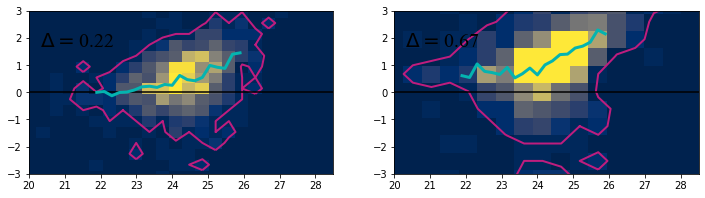

In [80]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
X,Y = flux2mag(a[:,1]),flux2mag(a[:,11])
plot_photcomp(X,Y,30)

plt.subplot(1,2,2)
X,Y = flux2mag(a[:,0]),flux2mag(a[:,15])
plot_photcomp(X,Y,30)
